In [1]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.regularizers import L1L2
from keras.layers import TextVectorization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statistics as stats
import glob
from keras.initializers import GlorotNormal
from keras.callbacks import EarlyStopping
from keras import optimizers

# B) Data Exploration and Pre-processing
## ii 
Remove the punctuation and numbers from the data.


In [79]:
# remove punctuation/numbers from files
bad_characters = '''!()-[]{};:'"\,<>./?@#$%^&*_~0123456789+'''
pos_directory = "../data/pos"
for filename in os.listdir(pos_directory):
    with open(f"{pos_directory}/{filename}", "r") as f:
        new_file = ''
        for line in f:
            for char in line:
                if char not in bad_characters:
                    new_file += char
        with open(f"{pos_directory}/{filename}", 'w') as nf:
            nf.write(new_file)


neg_directory = "../data/neg"
for filename in os.listdir(neg_directory):
    with open(f"{neg_directory}/{filename}", "r") as f:
        new_file = ''
        for line in f:
            for char in line:
                if char not in bad_characters:
                    new_file += char
        with open(f"{neg_directory}/{filename}", 'w') as nf:
            nf.write(new_file)



## iii.
The name of each text file starts with cv number. Use text files 0-699 in each class for training and 700-999 for testing.

In [5]:
# compile training and testing sets
training_files = []
testing_files = []

# https://stackoverflow.com/questions/16148951/python-looping-over-files-order
neg_path = "../data/neg"
filelist = glob.glob(os.path.join(neg_path, '*.txt'))
for i, file in enumerate(sorted(filelist, key=lambda s: s.lower())): 
    file_name = str(file).split('/')[-1]
    if i < 700:
        training_files.append(file_name)
    else:
        testing_files.append(file_name)


pos_path = "../data/pos"
filelist = glob.glob(os.path.join(pos_path, '*.txt'))
for i, file in enumerate(sorted(filelist, key=lambda s: s.lower())): 
    file_name = str(file).split('/')[-1]
    if i < 700:
        training_files.append(file_name)
    else:
        testing_files.append(file_name)

## iv.
Count the number of unique words in the whole dataset and print it out.

In [6]:
# find number of unique words

# get unique words in training set
unique_words = set()
for i, fil in enumerate(training_files):
    if i < 700:
        with open(f'{neg_path}/{fil}') as nt:
            for line in nt:
                elements = line.strip().split(' ')
                for el in elements:
                    unique_words.add(el)
    else:
        with open(f'{pos_path}/{fil}') as pt:
            for line in pt:
                elements = line.strip().split(' ')
                for el in elements:
                unique_words.add(el)

# get unique words in test set
for i, fil in enumerate(testing_files):
    if i < 300:
        with open(f'{neg_path}/{fil}') as n:
            for line in n:
                elements = line.strip().split(' ')
                for el in elements:
                    unique_words.add(el)
    else:
        with open(f'{pos_path}/{fil}') as p:
            for line in p:
                elements = line.strip().split(' ')
                for el in elements:
                    unique_words.add(el)
num_unique_words = len(unique_words)
print(f'There are {num_unique_words} unique words in the dataset')

There are 47341 unique words in the dataset


## v.
Calculate the average review length and the standard deviation of review lengths. Report the results.

In [7]:
# get lengths review length
review_lengths = []
for i, fil in enumerate(training_files):
    if i < 700:
        with open(f'{neg_path}/{fil}') as n:
            review_words = []
            for line in n:
                elements = line.strip().split(' ')
                review_words.extend(elements)
            review_lengths.append(len(review_words))
    else:
        with open(f'{pos_path}/{fil}') as p:
            review_words = []
            for line in p:
                elements = line.strip().split(' ')
                review_words.extend(elements)
            review_lengths.append(len(review_words))

for i, fil in enumerate(testing_files):
    if i < 300:
        with open(f'{neg_path}/{fil}') as n:
            review_words = []
            for line in n:
                elements = line.strip().split(' ')
                review_words.extend(elements)
            review_lengths.append(len(review_words))
    else:
        with open(f'{pos_path}/{fil}') as p:
            review_words = []
            for line in p:
                elements = line.strip().split(' ')
                review_words.extend(elements)
            review_lengths.append(len(review_words))

print(f'Average review length: {sum(review_lengths) / len(review_lengths)}')
print(f'Standard Deviation of review length: {round(stats.stdev(review_lengths), 2)}')

Average review length: 705.615
Standard Deviation of review length: 317.34


## vi
Plot the histogram of review lengths.

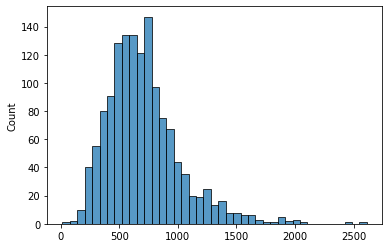

In [ ]:
# show histogram of review lengths
sns.histplot(review_lengths)
plt.show()

## vii.
Tokenize each text document. Rresent text using popularity/ rank of words in text. The most common word in the text will be represented as 1, the second most common word will be represented as 2, etc.

In [8]:
# tokenize train

# gather data
train_data = []
for i, fil in enumerate(training_files):
    if i < 700:
        with open(f'{neg_path}/{fil}') as n:
            file_str = ''
            for line in n:
                line = line.replace('\n', '')
                file_str += line
            train_data.append(file_str)
    else:
        with open(f'{pos_path}/{fil}') as p:
            file_str = ''
            for line in p:
                line = line.replace('\n', '')
                file_str += line
            train_data.append(file_str)

toke = Tokenizer()
toke.fit_on_texts(train_data)

tokened_train_set = toke.texts_to_sequences(train_data)

### viii. 
Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

In [9]:
L = int(np.quantile(review_lengths, .7))+1
L

805

### viii.
Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L

In [10]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
tokened_train_set = pad_sequences(tokened_train_set, maxlen=L, dtype='int32',
                            padding='post', truncating='post', value=0)
tokened_train_set

array([[   96,    80,   940, ...,     0,     0,     0],
       [    1,   694,  5575, ...,     0,     0,     0],
       [    9,     6,   106, ...,     0,     0,     0],
       ...,
       [  127,  2831,    15, ...,     0,     0,     0],
       [    2,  3186,  5014, ..., 16089,     6,  1915],
       [   77,   148,   102, ...,     0,     0,     0]], dtype=int32)

## C
### (i)
Create a word embedding layer, assume that we are interested in the top 5,000 words. This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000 words in the document. Choose the length of the embedding vector for each word to be 32. Hence, each document is represented as a 32 × L matrix.


In [11]:
# it looks like embedding no longer has a parameter to only track the top words
# instead, we can retokenize the data to adhere to this rule

toke2 = tf.keras.preprocessing.text.Tokenizer(num_words=5001)
toke2.fit_on_texts(train_data)
tokened_train_set = toke2.texts_to_sequences(train_data)
tokened_train_set = pad_sequences(tokened_train_set, maxlen=L, dtype='int32',
                            padding='pre', truncating='post', value=0)
embedding_layer = tf.keras.layers.Embedding(input_dim=num_unique_words, output_dim=32, input_length=L)
embedded_train = embedding_layer(tokened_train_set)
embedded_train

<tf.Tensor: shape=(1400, 805, 32), dtype=float32, numpy=
array([[[ 0.00719191,  0.01544954,  0.02707657, ..., -0.04942069,
         -0.02606099, -0.0073908 ],
        [ 0.00719191,  0.01544954,  0.02707657, ..., -0.04942069,
         -0.02606099, -0.0073908 ],
        [ 0.00719191,  0.01544954,  0.02707657, ..., -0.04942069,
         -0.02606099, -0.0073908 ],
        ...,
        [ 0.03827539,  0.02033791, -0.00362938, ...,  0.03878548,
          0.02593062, -0.01979482],
        [ 0.01891765, -0.04801756, -0.03834288, ...,  0.01420356,
          0.02272571, -0.0087346 ],
        [ 0.00535649,  0.04210785, -0.04596635, ..., -0.00059006,
         -0.04209558,  0.01180138]],

       [[ 0.00719191,  0.01544954,  0.02707657, ..., -0.04942069,
         -0.02606099, -0.0073908 ],
        [ 0.00719191,  0.01544954,  0.02707657, ..., -0.04942069,
         -0.02606099, -0.0073908 ],
        [ 0.00719191,  0.01544954,  0.02707657, ..., -0.04942069,
         -0.02606099, -0.0073908 ],
        ..

### ii
Flatten the matrix of each document to a vector

In [12]:
# flatten each matrix individually
flattened_train = layers.Flatten()(embedded_train)
flattened_train

<tf.Tensor: shape=(1400, 25760), dtype=float32, numpy=
array([[ 0.00719191,  0.01544954,  0.02707657, ..., -0.00059006,
        -0.04209558,  0.01180138],
       [ 0.00719191,  0.01544954,  0.02707657, ..., -0.00114627,
         0.01566447, -0.02350392],
       [ 0.00719191,  0.01544954,  0.02707657, ...,  0.00887281,
        -0.04853643, -0.01348697],
       ...,
       [ 0.00719191,  0.01544954,  0.02707657, ...,  0.04748404,
         0.00669814,  0.04395504],
       [ 0.03778629, -0.02985847, -0.00987934, ..., -0.03778755,
         0.02728918,  0.03072888],
       [ 0.00719191,  0.01544954,  0.02707657, ...,  0.00571297,
        -0.01154128, -0.01169013]], dtype=float32)>

# D) Multi-Layer Perceptron
## i
Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

In [13]:
model = Sequential()
model.add(layers.Embedding(input_dim=num_unique_words, output_dim=32, input_length=L))
model.add(layers.Flatten())
model.add(Dense(50, activation='relu', use_bias=True))
model.add(layers.Dropout(.2))
model.add(Dense(50, activation='relu', use_bias=True))
model.add(layers.Dropout(.5))
model.add(Dense(50, activation='relu', use_bias=True))
model.add(layers.Dropout(.5))
model.add(Dense(1, activation='sigmoid', use_bias=True))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [14]:
# fit/evaluate on training data
X_train = np.array(tokened_train_set.copy())
# X_train = flattened_train
y_train = 700*[0]
y_train.extend(700*[1])
y_train = np.array(y_train).reshape((-1,1))


model.fit(X_train,
          y_train,
          epochs=2,
          batch_size=10)
model.evaluate(X_train, y_train)

Epoch 1/2
140/140 [==============================] - 4s 3ms/step - loss: 0.6993 - accuracy: 0.5279
Epoch 2/2
44/44 [==============================] - 0s 2ms/step - loss: 0.5214 - accuracy: 0.8764


[0.5214340686798096, 0.8764285445213318]

In [15]:
# gather test data
test_files = []
for i, fil in enumerate(testing_files):
    if i < 300:
        with open(f'{neg_path}/{fil}') as n:
            file_str = ''
            for line in n:
                file_str += line
            test_files.append(file_str)
    else:
        with open(f'{pos_path}/{fil}') as p:
            file_str = ''
            for line in p:
                file_str += line
            test_files.append(file_str)

y_test = 300*[0]
y_test.extend(300*[1])
y_test = np.array(y_test).reshape((-1,1))
# tokenize test set
tokened_test_set = toke2.texts_to_sequences(test_files)
tokened_test_set = pad_sequences(tokened_test_set, maxlen=L, dtype='int32',
                            padding='pre', truncating='post', value=0)

In [16]:
# test MLP model on test data
results = model.evaluate(tokened_test_set, y_test)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

19/19 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.5867
Test Loss: 0.6746158003807068
Test Accuracy: 0.5866666436195374


The test results indicate that our MLP is a random classifier. Obviously MLP is not an ideal model for sentiment analysis

# E) One-Dimensional Convolutional Neural Network
Although CNNs are mainly used for image data, they can also be applied to text data, as text also has adjacency information.

## i
After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [17]:
# construct and compile CNN
cnn = Sequential()
cnn.add(layers.Embedding(input_dim=num_unique_words, output_dim=32, input_length=L))
cnn.add(layers.Conv1D(kernel_size=3, filters=32))
cnn.add(layers.MaxPooling1D(strides=2, pool_size=2))
cnn.add(layers.Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(layers.Dropout(.2))
cnn.add(Dense(50, activation='relu'))
cnn.add(layers.Dropout(.5))
cnn.add(Dense(50, activation='relu'))
cnn.add(layers.Dropout(.5))
cnn.add(Dense(1,  activation='sigmoid'))

cnn.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

## ii
Report the train and test errors

In [18]:
cnn.fit(X_train, 
        y_train,
        epochs=2,
        batch_size=10)
cnn.evaluate(tokened_train_set, y_train)

Epoch 1/2
140/140 [==============================] - 9s 4ms/step - loss: 0.7016 - accuracy: 0.4914
Epoch 2/2
44/44 [==============================] - 0s 2ms/step - loss: 0.5943 - accuracy: 0.7964


[0.5942940711975098, 0.7964285612106323]

In [19]:
results = cnn.evaluate(tokened_test_set, y_test)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

19/19 [==============================] - 0s 2ms/step - loss: 0.6564 - accuracy: 0.6583
Test Loss: 0.6563624143600464
Test Accuracy: 0.6583333611488342


# F) **Long Short-Term Memory Recurrent Neural Network**
The structure of the LSTM we are going to use is shown in the following figure.
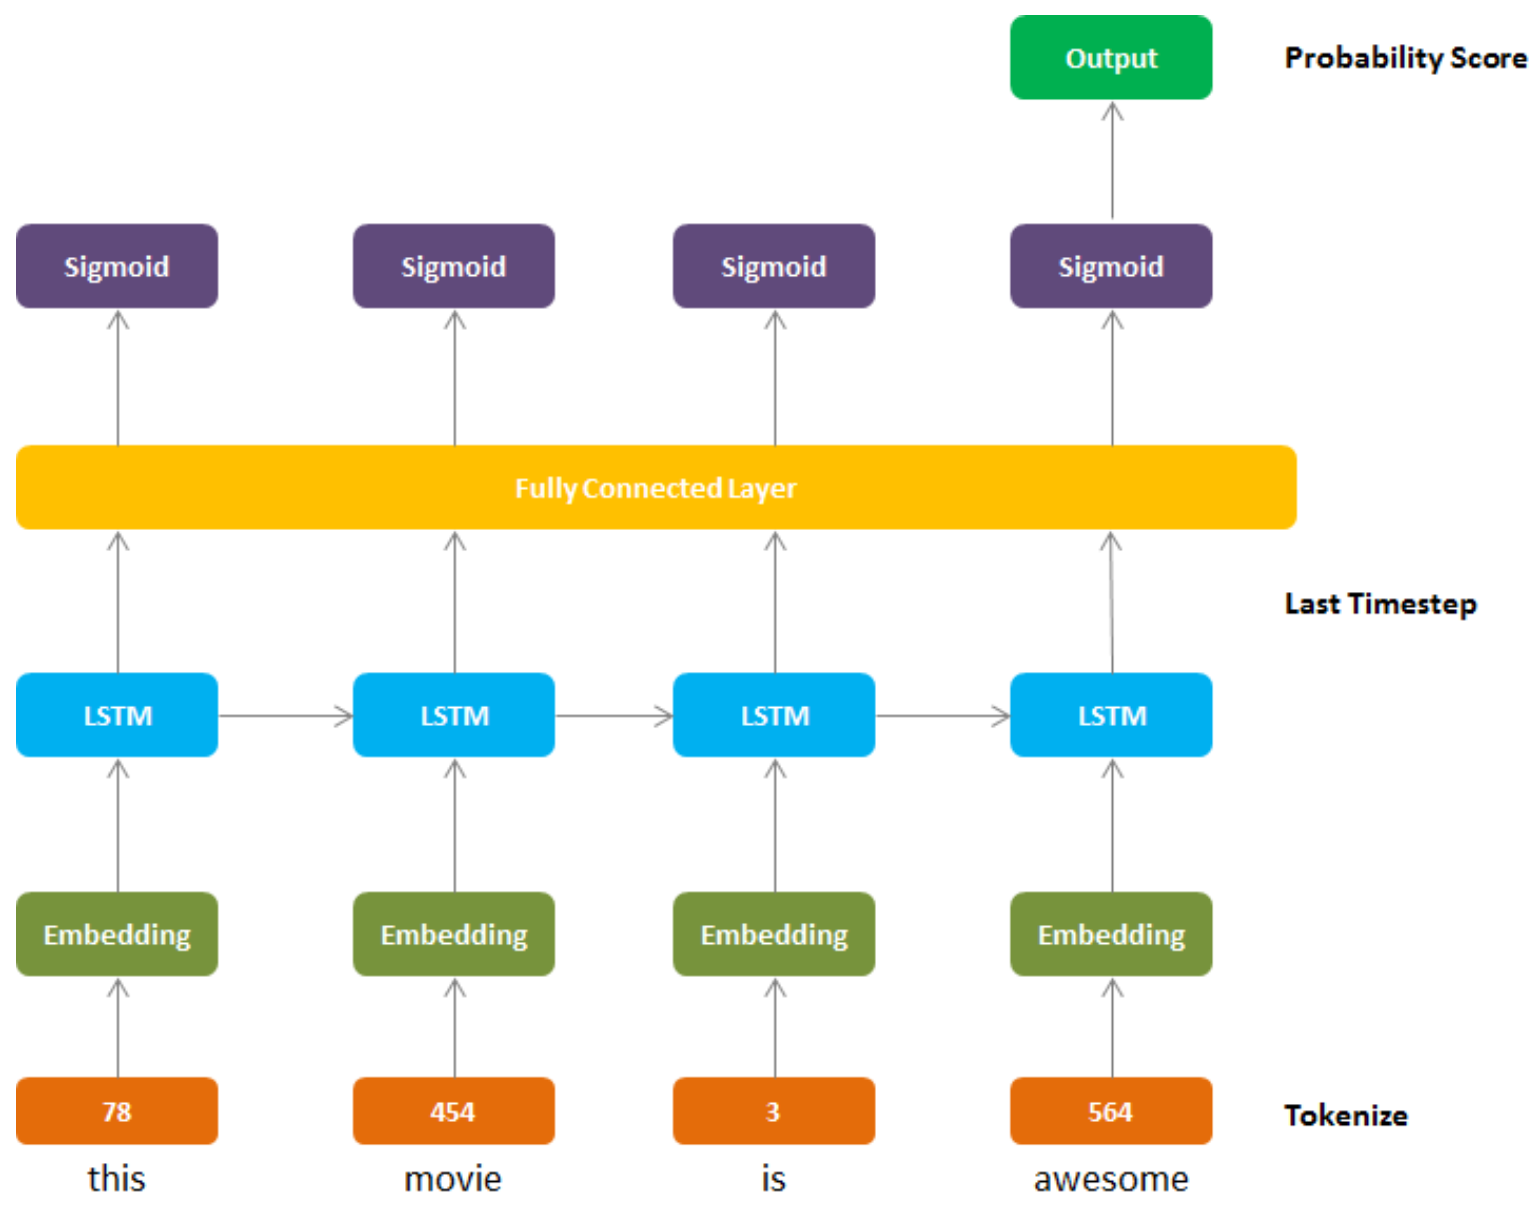

## i. 
Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.

In [20]:
# construct and compile LSTM RNN
rnn = Sequential()
rnn.add(layers.Embedding(input_dim=num_unique_words, output_dim=32, input_length=L))
model.add(layers.BatchNormalization())
rnn.add(layers.LSTM(256, use_bias=True, dropout=.2))
rnn.add(layers.Flatten())
rnn.add(Dense(256, activation='relu', use_bias=False))
rnn.add(layers.Dropout(.2))
rnn.add(Dense(1, activation='sigmoid', use_bias=False))

rnn.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [22]:
rnn.fit(X_train,
        y_train,
        epochs=10,
        batch_size=10)
rnn.evaluate(tokened_train_set)

Epoch 1/10
140/140 [==============================] - 7s 48ms/step - loss: 0.6110 - accuracy: 0.6993
Epoch 2/10
140/140 [==============================] - 7s 48ms/step - loss: 0.4807 - accuracy: 0.8129
Epoch 3/10
140/140 [==============================] - 7s 48ms/step - loss: 0.8234 - accuracy: 0.5871
Epoch 4/10
140/140 [==============================] - 7s 49ms/step - loss: 0.5922 - accuracy: 0.6864
Epoch 5/10
140/140 [==============================] - 7s 48ms/step - loss: 0.4749 - accuracy: 0.7750
Epoch 6/10
140/140 [==============================] - 7s 49ms/step - loss: 0.3884 - accuracy: 0.8186
Epoch 7/10
140/140 [==============================] - 7s 49ms/step - loss: 0.2208 - accuracy: 0.9100
Epoch 8/10
140/140 [==============================] - 7s 49ms/step - loss: 0.2266 - accuracy: 0.9071
Epoch 9/10
140/140 [==============================] - 7s 49ms/step - loss: 0.1375 - accuracy: 0.9407
Epoch 10/10
44/44 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accur

[0.0, 0.0]

In [23]:
results = rnn.evaluate(tokened_test_set, y_test)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

19/19 [==============================] - 1s 23ms/step - loss: 1.4938 - accuracy: 0.6417
Test Loss: 1.4938122034072876
Test Accuracy: 0.6416666507720947
